### Project 2 - Mobile Robotics - MO651
#### __Professor:__ _Esther Luna Columbini_ <br>
__Students:__ <br>
<table style="margin:0; padding:3px;">
    <tr><td><em>Tito Barbosa Rezende </td><td><strong>RA:</strong> 025327</td></tr>
<tr><td><em>João Paulo Franco Assumpção </td><td><strong>RA:</strong> 229322</td></tr>
<tr><td><em>Elcio Pereira de Souza Junior </td><td><strong>RA:</strong> 262952</td></tr></table>

### Pre-requisites

Necessary libraries:

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install scikit-fuzzy

Import libraries:

In [1]:
import sys, time
sys.path.insert(0, '../src')
from IPython.display import clear_output
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import random
import collections
from datetime import datetime
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## 1 - First assigment classes and functions

### 1.1 Laser Sensor

In [2]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

def plot_laser_robot_frame():
    fig, ax = plt.subplots()
    #posição dos feixes laser
    ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='o')
    #posição do centro do robo
    ax.scatter(0, 0, 40, c='b', marker='o')
    plt.show()

### 1.2 Sonar Sensors

In [3]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
        
    def get_left_distance(self):
        self.update_raw_reading()
        return np.min(np.array(self.data["raw_reading"][0]))
    
    def get_front_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][3:5]]))        
    
    def get_right_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][7:9]]))
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(us_sensors.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY

We defined __toGlobal__ function to enable a later using. The function transform any _(x,y)_ point of robot reference into a global reference.

In [4]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]
def fromGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,-robot_x],[0,1,-robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),math.sin(robot_ang),0],[-math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_rot,T_trans)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    ang = np.arctan2(res[1],res[0])
    return res[0],res[1], ang

### 1.3 Kinematic Model

In [18]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        # Motor handles
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        # Calculate axis distances
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        # axis
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        # Verify robot position on start
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]
        # Record both initial position e actual position
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
    
        # Store List of position points
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()    
        #Initial wheel encoders position
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        #Calculation interval
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_oneshot_wait)
        return jL
    
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_oneshot_wait)
        return jR    
    
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        self.enc_Theta = self.enc_Theta + qsi[2]
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def turnGlobal(self, input_ang):
        orientation = self.robot.get_current_orientation()[2]
        ang = input_ang
        if (orientation < -math.pi):
            orientation = orientation + 2*math.pi
        if (orientation > math.pi) :
            orientation = orientation - 2*math.pi
        if (ang < -math.pi):
            ang = ang + 2*math.pi
        if (ang > math.pi) :
            ang = ang - 2*math.pi
            
        print("Initial orientation ", orientation)
        print("Ang ", ang)
        vel = 0.2
        new_orientation = ang - orientation
        if (new_orientation > math.pi):
            new_orientation = new_orientation -2*math.pi
        if (new_orientation < -math.pi):
            new_orientation = new_orientation +2*math.pi
        if (new_orientation > 0) :
            vel=-vel
        self.robot.set_right_velocity(vel)
        self.robot.set_left_velocity(-vel)
        tolerance = math.pi/90
        if ((ang - orientation) > tolerance) or ((ang - orientation) < -tolerance):
            #time.sleep(0.05)
            orientation = self.robot.get_current_orientation()[2]
            if (orientation < 0):
                orientation = orientation + 2*math.pi
            sys.stdout.write("\r" + "Diff " + str((ang - orientation)) + " orientation " + str(orientation))
            sys.stdout.flush()
        #self.robot.stop()
        print("curr orientation ", orientation)
        return vel, -vel
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
  
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].set_title('Odometry')
        ax[0].scatter(enc_path[:,0], enc_path[:,1], 5, c='b', marker='o')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax[1].set_title("True Path")
        ax[1].scatter(true_path[:,0], true_path[:,1], 5, c='r', marker='o')

### 1.4 Point Cloud

In this class we create a point cloud from distances provided by LIDAR and SONAR sensors based on robot coordination and transformed in global coordination (over translation and rotation method. After gettting the points, we plot them on a graphic.

In [1]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
    
    def update(self):
        #Store the actual position
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        # Update the point cloud data using LIDAR
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        # Update the point cloud data using SONAR
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convert point cloud into array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        # Get the centre of robot
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        # Plot SONAR Point Cloud
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        # Plot the centre of Robot
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        # Plot LIDAR Point Cloud
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()

## 2 - Code of Project 2

The general objective of this work is to build, on the V-REP robotic simulator, a set of behaviors to control a Pioneer P3-DX robot.
3 Behaviours were developed:<br>
    <blockquote>2.1 AvoidObstacle<br>
    2.2 WallFollow<br>
    2.3 GoToGoal</blockquote>

### 2.1 - AvoidObstacle

This behaviour was implemented using Fuzzy logic. In other to correctlly demonstrate the behaviour, a simple wandering algorithim is simulated bellow

Start robot and test the 8 frontal sonar sensors.

In [8]:
robot = Robot()
distances = robot.read_ultrassonic_sensors()
frontal = distances[:8]
print(frontal)

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


First, bellow Fuzzyfication function was implemented, receiving as its input the reading of the sonar sensors. The eight frontal sonar sensors was classified into 3 groups: left sensors (__x_l:__ 1 to 3 sensors); forward (__x_f:__ 3 to 6 sensors) and; right (__x_r:__ 6 to 8 sensors). For fuzzification we adopted the minimal value each one.

We choose 0.1m as __near__ and values between 0.1 and 0.4m as __almost near__. Far value was considered irrelevant in results.

The function print a graphic result if you set the __\_print__ value to __1__.

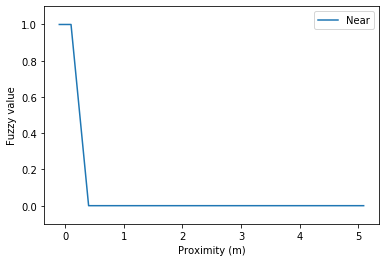

In [9]:
def sensor_fuzzyfication(frontal_sensors,_print=0, _near=0.1, _almost_near=0.4) :
    x_v = np.arange(-0.1, 5.1, 0.01)
    t_close = [-0.1, -0.1, _near, _almost_near]
    mfx_close = fuzz.trapmf(x_v, t_close)
    #t_far = [0.3, .55, 5, 5]                /// Results are irrelevant
    #mfx_far = fuzz.trapmf(x_v, t_far)       /// Results are irrelevant
    x_l = np.array([round(min(frontal_sensors[:2]))])    # Left sensors
    x_f = np.array([min(frontal_sensors[3:5])])          # Forward Sensors
    x_r = np.array([round(min(frontal_sensors[6:8]),1)]) # Right sensors
    y_l = np.array([-1]) # Null value
    y_f = np.array([-1]) # Null value
    y_r = np.array([-1]) # Null value
    if(x_l[0] < _almost_near) :
        y_l = fuzz.trapmf(x_l, t_close) # Return fuzzy value for left sensors
    if(x_f[0] < _almost_near) :
        y_f = fuzz.trapmf(x_f, t_close) # Return fuzzy value for forward sensors
    if(x_r[0] < _almost_near) :
        y_r = fuzz.trapmf(x_r, t_close) # Return fuzzy value for right sensors
    
    # Just for print mode
    if (_print > 0) : 
        plt.plot(x_v, mfx_close,label="Near")
        colors = ['tab:black','tab:cyan','tab:purple','tab:green','tab:red','tab:brown','tab:olive','tab:gray','tab:pink']
        if(x_l[0] < 1) : plt.vlines(x_l, 0, y_l, label="min_left",color=colors[1]); print("Left sensors fuzzyfication: "+str(y_l[0]))
        if(x_f[0] < 1) : plt.vlines(x_f, 0, y_f, label="min_forward",color=colors[2]); print("Forward sensors fuzzyfication: "+str(y_f[0]))
        if(x_r[0] < 1) : plt.vlines(x_r[0], 0, y_r, label="min_right",color=colors[3]); print("Right sensors fuzzyfication: "+str(y_r[0]))
        plt.ylabel('Fuzzy value')
        plt.xlabel('Proximity (m)')
        plt.ylim(-0.1, 1.1)
        plt.legend(loc=1)
        plt.draw()
        plt.pause(0.05)
    
    # Return useful value: used X range; Y result values and; near trapezoidal.
    return x_v, y_l, y_f, y_r, t_close

fuzzy = sensor_fuzzyfication(frontal,1)

Then, the object avoidance will be given by the defuzzyfication function bellow, acting in oposition to the proximitiy sensor. The function starts an initial verification if the frontal sensors minimal value is grater than 0.4m (our almost near value). In this case it returns the angular velocity equal 2 to both wheels. Else, it goes to defuzzification angular velocity.

In [36]:
def avoidByDefuzzyfication(frontal_sensors,fuzzy_results, _print=0) :
    if (min(frontal_sensors) > fuzzy_results[4][3]) : # in case all frontal sensor is grater than almost near
        velL = 2
        velR = 2
        return velL, velR           # Stop function and return equal values. 
                                    # This condition avoid a defuzzy error obtaining a null crisp value
    y_v = np.arange(-95, 95, 1)
    x_v = fuzzy_results[0]

    mfy_left = fuzz.trimf(y_v, [-95, -95,-10])       # Values to get  a left collision probabillity
    mfy_forward = fuzz.trapmf(y_v, [-60,-30, 30,60]) # Values to get  a forward collision probabillity
    mfy_right = fuzz.trimf(y_v, [10,95,95])          # Values to get  a right collision probabillity

    proximityL = ctrl.Antecedent(x_v, 'proximityL')
    proximityR = ctrl.Antecedent(x_v, 'proximityR')
    proximityF = ctrl.Antecedent(x_v, 'proximityF')
    prob = ctrl.Consequent(y_v, 'Collision')         # Collision probabillity

    proximity = fuzz.trapmf(x_v,[-0.1, -0.1, fuzzy_results[4][2], fuzzy_results[4][3]])
    proximityL['near'] = proximity
    proximityR['near'] = proximity
    proximityF['near'] = proximity
    prob['Left'] = mfy_left
    prob['Forward'] = mfy_forward
    prob['Right'] = mfy_right


    # This method define 3 rules to get our fuzzy set
    rule1 = ctrl.Rule(proximityL['near'] , prob['Left'])
    rule2 = ctrl.Rule(proximityF['near'] , prob['Forward'])
    rule3 = ctrl.Rule(proximityR['near'], prob['Right'])

    vel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3]) # Defuzzy rules for collision possibility
    vel = ctrl.ControlSystemSimulation(vel_ctrl)

    vel.input['proximityL'] = min(frontal_sensors[:3])
    vel.input['proximityR'] = min(frontal_sensors[5:8])
    vel.input['proximityF'] = min(frontal_sensors[2:6])

    if (_print > 0) :
        # Print minimal sensor distances
        print("Distance Left: "+str(min(frontal[:3])))
        print("Distance Forward: "+str(min(frontal[2:6])))
        print("Distance Right: "+str(min(frontal[5:8])))

    vel_output = 1

    if (min(frontal_sensors) <= 1):
        vel.compute()
        # Using Mamdani's method we output a fuzzy set 
        # and obtain a crisp value from centroid
        
        vel_output = round(vel.output['Collision'])   # Collision angle probabillity crisp value
        Collision = "Collision: "+str(vel_output)+"°"
    else: Collision = "No collision"
    if (_print > 0) :
        print(Collision)
        prob.view(sim=vel)
    
    x_w = np.arange(-100,100,0.1)
    wlv = [-100, -100,0,50]    # Fuzzify crisp value to obtain left wheel angular velocity
    wrv = [0,10,100,100]       # Fuzzify crisp value to obtain right wheel angular velocity
    # We use diferent trapezoidal graphics for the wheels to avoid equal speed in frontal collision possibility
    
    x = np.array([vel_output])
    y_l=fuzz.trapmf(x, wlv)    # Fuzzy value for left wheel
    y_r=fuzz.trapmf(x, wrv)    # Fuzzy value for right wheel
    if (_print > 0) :
        #Print graphics
        WheelL = fuzz.trapmf(x_w, wlv)
        WheelR = fuzz.trapmf(x_w, wrv)
        plt.plot(x_w, WheelL,label="Wheel Left")
        plt.plot(x_w, WheelR,label="Wheel Right")
        plt.vlines(x, 0, y_l, label="Collision")
        plt.vlines(x, 0, y_r)
        plt.legend()
        plt.draw()
        plt.pause(0.05)
        print("Wheel left angular velocity: "+str((y_l[0]-0.5)/0.25))
        print("Wheel right angular velocity: "+str((y_r[0]-0.5)/0.25))
    
    velL = (y_l[0]-0.5)/0.5    #Convert Fuzzy value into angular speed for left wheel
    velR = (y_r[0]-0.5)/0.5    #Convert Fuzzy value into angular speed for right wheel

    return velL, velR
avoidByDefuzzyfication(frontal,fuzzy,1)

(2, 2)

Our mobile robot class, implementing the fuzzy controller will be given by:

In [11]:
class MobileRobotAvoid():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.compute_interval = 0.2
        
    def control(self, frontal):
        fuzzy = sensor_fuzzyfication(frontal)
        avoid = avoidByDefuzzyfication(frontal,fuzzy)    # Defuzzyfication
        return avoid[0], avoid[1]                        # Return angular speed from the sensors

    def startWander(self, seconds):
        
        for step in range(int(seconds/self.compute_interval)): # Repeat avoidance each 0.2s (self.compute_interval)
            Phi_l, Phi_r = self.control(self.robot.read_ultrassonic_sensors()[:8]) # Get angular speed from avoidance function
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)           # Apply angular speed to kinematic model
            
mr = MobileRobotAvoid()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Bellow, test startWander function for 50s.

In [ ]:
mr.startWander(50)

__Conclusion:__ We tested __startWander__ function for 60 minutes and the robot didn't collide or stop, avoiding each obstacle.

### 2.2 - Wall Follow

This behaviour was implemented using a PID controller. In other to demonstrate the behaviour, two classes were created.One of the PID controller itselft, and the other a Robot Class, which uses the previous work of Project 1 kinematic model and sensors.

#### 2.2.1 PID Controller

The PID gains were obtained experimentally. Both Integral and Derivative did not performed well on hour case, specially during the countour of the couch. For P gains lower than 1, the robot is too slow to correct its trajectory and ocasionally the distance of the wall becomes greather than 1 meter and the robot stops following the wall. If the P gain is too high, the controller correction is too great and the robot overshots, turning around its own axis trying to go back to the wall, which causes the left sensor to loose the wall reading.
We can perceive here that with the controller alone is very dificult to guide the robot. Thus, there is a need for a behaviour coordination strategy.

In [12]:
class PID():
    def __init__(self, P=1, I=0.0, D=0, Derivator=0, Integrator=0, Integrator_max=500, Integrator_min=-500):
        self.Kp=P
        self.Ki=I
        self.Kd=D
        self.Derivator=Derivator
        self.Integrator=Integrator
        self.Integrator_max=Integrator_max
        self.Integrator_min=Integrator_min
        self.set_point=0.0
        self.error=0.0
        self.IntegralWindow = collections.deque(maxlen=10)
        
    def update(self,current_value):
        self.error = self.set_point - current_value
        self.P_value = self.Kp * self.error
        self.D_value = self.Kd * ( self.error - self.Derivator)
        self.Derivator = self.error
        self.IntegralWindow.append(self.error)
        self.Integrator = sum(self.IntegralWindow)

        if self.Integrator > self.Integrator_max:
            self.Integrator = self.Integrator_max
        elif self.Integrator < self.Integrator_min:
            self.Integrator = self.Integrator_min

        self.I_value = self.Integrator * self.Ki

        PID = self.P_value + self.I_value + self.D_value
        #print("PID cv ",current_value ," sp ", self.set_point ," error ", self.error ," pid ", PID)
        sys.stdout.write("\r" + "PID cv " + str(current_value) + " sp " + str(self.set_point) + " error " + str(self.error) + " pid " + str(PID))
        sys.stdout.flush()
        return PID

    def setPoint(self,set_point):
        self.set_point = set_point
        self.Integrator=0
        self.Derivator=0

In [13]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.pidL = PID()
        self.pidL.setPoint(0.5)
        self.compute_interval = 0.5
        self.follow_wall_side = "LEFT"
        
        self.curr_state = None
        self.prev_state = None
        
    def checkCurrentState(self):
        previous_state = self.curr_state
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        #Initial state: Move Foward
        if (previous_state == None and self.prev_state == None):
            self.curr_state = 'MoveFoward'
    
        #MF->TR
        if (previous_state == 'MoveFoward' and front <= 0.5):
            self.curr_state = 'TurnRight'
            
        #TR->WF
        if (previous_state == 'TurnRight' and left <= 1):
            self.curr_state = 'WallFollow'
            
        #WF->TR
        if (previous_state == 'WallFollow' and front <= 0.5):
            self.curr_state = 'TurnRight'
            
        #WF->MoveFoward
        if (previous_state == 'WallFollow' and front == 5 and left == 5):
            self.curr_state = 'MoveFoward'
          
        #update prev
        self.prev_state = previous_state
    
    def control(self, left_distance, right_distance, front_distance ):
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        vel = 0
        turn = 0
        self.checkCurrentState()
        
        #State Machine
        ##Move foward
        if (self.curr_state == 'MoveFoward'):
            turn = 0
            vel = 3
        ##Turn Right
        elif (self.curr_state == 'TurnRight'):
            turn = 1
            vel = 0
        #Wall Follow
        elif (self.curr_state == 'WallFollow'):
            turn = self.pidL.update(left_distance)
            vel = 1
        #Turn Back
#         elif (self.curr_state == 'TurnBack'):
#             turn = -1
#             vel = 0
        self.prev_state = self.curr_state
        return vel + turn, vel - turn

    def start(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.control(self.us_sensors.get_left_distance(),self.us_sensors.get_right_distance(), self.us_sensors.get_front_distance())
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Bellow test wall follow fo 50s.

In [115]:
mr.start(50)

PID cv 0.38602718710899353 sp 0.5 error 0.11397281289100647 pid 0.11397281289100647776

### 2.3 Go To Go

Instead of moving forward on robot current direction, we could implement a behaviour to Go to a specific point on the global reference.
The implementation is given by the following function

In [14]:
def give_diretion(robot, us_sensors, go_point_x, go_point_y, _print=0):
    
    # global position of robot
    robot_x = robot.get_current_position()[0]
    robot_y = robot.get_current_position()[1]
    robot_ang = robot.get_current_orientation()[2]
    
    # relative vector to goal
    vec_x_go = go_point_x - robot_x
    vec_y_go = go_point_y - robot_y
    
    # angle between position and goal vector
    # vector origin
    
    ang = math.acos( vec_x_go / ( math.sqrt(math.pow(vec_x_go,2)+math.pow(vec_y_go,2)) ) )

    if (_print==1):
        print("ang:")
        print(ang)
        print("ang robot:")
        print(robot_ang)
    
    if robot_y > 0:
        ang = -ang

    if (_print==0):
        print("After:")
        print(robot.get_current_orientation()[2])

        # plot
        plt.plot([0,0],[-7.5,7.5], color='g')
        plt.plot([-7.5,7.5], [0,0], color='r')
        origin = [robot_x, robot_y]

        plt.quiver(*origin, vec_x_go, vec_y_go, color=['b'])

        plt.axis([-7.5,7.5,-7.5,7.5])
        plt.show()
        
    return ang

In [15]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.compute_interval = 0.5
        self.follow_wall_side = "LEFT"
        
        self.curr_state = None
        self.prev_state = None
        
        self.go_x = 0
        self.go_y = 0
    
    # Find direction for the destination point
    def direction(self):
        return give_diretion(self.robot, self.us_sensors, self.go_x, self.go_y, 1)
        
    # Set destination point
    def setGoal(self, x, y):
        self.go_x = x
        self.go_y = y
        
    # Check if the robot has reached destination
    def checkFinal(self):
        curr_x, curr_y = self.kinematicModel.true_global_position()
        return (abs(curr_x - self.go_x) < 0.1) and (abs(curr_y - self.go_y) < 0.1)
    
    def checkCorrectDirection(self):
        go_direction = self.direction()
        robot_direction = self.robot.get_current_orientation()[2]
        print("Go direction ", go_direction, "Robot direction ", robot_direction)
        return (abs(go_direction - robot_direction) < 0.1)
        
    def checkCurrentState(self):
        previous_state = self.curr_state
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        
        
        #Initial state: Turn to Direction
        if (previous_state == None and self.prev_state == None):
            self.curr_state = 'Turn'
    
        #Turn->MoveForward
        if (previous_state == 'Turn' and self.checkCorrectDirection()):
            self.curr_state = 'MoveForward'
            
        #MoveForward->Turn
        if (previous_state == 'MoveForward' and not self.checkCorrectDirection()):
            self.curr_state = 'Turn'
            
        #MoveForward->Final
        if (previous_state == 'MoveForward' and self.checkFinal()):
            self.curr_state = 'Final'
          
        #update prev
        self.prev_state = previous_state
        
        print(self.curr_state)
    
    # Behavior controller
    def control(self, left_distance, right_distance, front_distance ):
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        vel = 0
        turn_l = 0
        turn_r = 0
        self.checkCurrentState()
        
        #State Machine
        ##Turn
        if (self.curr_state == 'Turn'):
            vel = 0
            turn_l, turn_r = self.kinematicModel.turnGlobal(self.direction())
        ##MoveForward
        elif (self.curr_state == 'MoveForward'):
            turn_l = 0
            turn_r = 0
            vel = 2
        #Final: stop the robot
        elif (self.curr_state == 'Final'):
            turn_l = 0
            turn_r = 0
            vel = 0
            self.robot.stop()
        self.prev_state = self.curr_state
        return vel + turn_l, vel + turn_r

    def start(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.control(self.us_sensors.get_left_distance(),self.us_sensors.get_right_distance(), self.us_sensors.get_front_distance())
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            if (self.checkFinal()):
                print("You have reached your destination!")
                break
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Start GotoGoal without set a destination point. Thus robot goes to Global origin (0,0). For set a point, write __mr.setGoal(x,y)__ bellow before start function.

In [36]:
mr.start(100)

Turn
ang:
0.18895856206114625
ang robot:
1.4535495042800903
Initial orientation  1.4535495042800903
Ang  6.09422674511844
Diff 4.640677240838349 orientation 1.4535495042800903curr orientation  1.4535495042800903
ang:
0.18895464071552248
ang robot:
1.4535435438156128
Go direction  -0.18895464071552248 Robot direction  1.4535435438156128
Turn
ang:
0.18895464071552248
ang robot:
1.4535435438156128
Initial orientation  1.4535435438156128
Ang  6.094230666464064
Diff 4.640688553159926 orientation 1.4535421133041382curr orientation  1.4535421133041382
ang:
0.18895374396198025
ang robot:
1.447745680809021
Go direction  -0.18895374396198025 Robot direction  1.447745680809021
Turn
ang:
0.18895374396198025
ang robot:
1.447745680809021
Initial orientation  1.447745680809021
Ang  6.094231563217606
Diff 4.646485882408585 orientation 1.447745680809021curr orientation  1.447745680809021
ang:
0.18895200693762784
ang robot:
1.4477431774139404
Go direction  -0.18895200693762784 Robot direction  1.4477431

KeyboardInterrupt: 

### 2.4 Behaviour Coordenation

In [43]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.pidL = PID()
        self.pidL.setPoint(0.5)
        self.pidR = PID()
        self.pidR.setPoint(0.5)
        self.compute_interval = 0.5
   
        self.go_x = 0
        self.go_y = 0
    
    # Find direction for the destination point
    def direction(self):
        return give_diretion(self.robot, self.us_sensors, self.go_x, self.go_y, 1)
        
    # Set destination point
    def setGoal(self, x, y):
        self.go_x = x
        self.go_y = y
        
    # Check if the robot has reached destination
    def checkFinal(self):
        curr_x, curr_y = self.kinematicModel.true_global_position()
        return (abs(curr_x - self.go_x) < 0.1) and (abs(curr_y - self.go_y) < 0.1)
    
    def checkCorrectDirection(self):
        go_direction = self.direction()
        robot_direction = self.robot.get_current_orientation()[2]
        print("Go direction ", go_direction, "Robot direction ", robot_direction)
        return (abs(go_direction - robot_direction) < 0.1)
    
    # Avoid obstacles using fuzzy logic
    def fuzzyControl(self):
        frontal = self.robot.read_ultrassonic_sensors()[:8]
        fuzzy = sensor_fuzzyfication(frontal,0,0.05,0.2) # Call function fuzzy and set near=0.05 and almost_near=0.1
        avoid = avoidByDefuzzyfication(frontal,fuzzy)
        return avoid[0], avoid[1]
    
    # Follow the wall
    def wallFollowControl(self):
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        vel = 0
        turn = 0
        
        #Wall Follow
        if (left < right):
            turn = self.pidL.update(left)
            vel = 1
        else:
            turn = self.pidR.update(right)
            vel = 1
            
        return vel + turn, vel - turn
    
    # Subsumption behavior controller
    def control(self):
        vel_l = 0
        vel_r = 0
    
        
        min_frontal = np.min(np.array(self.robot.read_ultrassonic_sensors()[:8]))
        min_rear = np.min(np.array(self.robot.read_ultrassonic_sensors()[9:15]))
        
        #1st Priority: React rear collision possibility
        if (min_rear < 0.1) :
            vel_l, vel_r = [2.0,2.0]
        #2nd Priority: Avoid Obstacle
        elif (min_frontal <= 0.18 and min_rear > 0.1):
            vel_l, vel_r = self.fuzzyControl()
            print("Avoid Obstacle")
        #3th Priority: Turn to destination direction
        elif (not self.checkCorrectDirection()):
            vel_l, vel_r = self.kinematicModel.turnGlobal(self.direction())
            vel_l = vel_l + 0.2
            vel_r = vel_r + 0.2
            print("Turn")
        #4th Priority: Go Forward
        else:
            vel_l = 2
            vel_r = 2
            print("Go Forward")
        return vel_l, vel_r

    def start(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.control()
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            if (self.checkFinal()):
                self.robot.stop()
                print("You have reached your destination!")
                self.kinematicModel.plot_paths()
                self.point_cloud.update()
                self.point_cloud.plot_point_cloud()
                break
                
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Start _GotoGoal Subsumption Behavior_ without set a destination point. Thus robot goes to Global origin (0,0). For set a point, write __mr.setGoal(x,y)__ bellow before start function.

In [44]:
mr.start(100)

ang:
0.7918621520063139
ang robot:
2.14780855178833
Go direction  0.7918621520063139 Robot direction  2.14780855178833
ang:
0.7918621520063139
ang robot:
2.14780855178833
Initial orientation  2.14780855178833
Ang  0.7918621520063139
Diff -1.3559463997820163 orientation 2.14780855178833curr orientation  2.14780855178833
Turn
ang:
0.7871931248673859
ang robot:
2.055356502532959
Go direction  0.7871931248673859 Robot direction  2.055356502532959
ang:
0.7871931248673859
ang robot:
2.055356502532959
Initial orientation  2.055356502532959
Ang  0.7871931248673859
Diff -1.268163377665573 orientation 2.055356502532959curr orientation  2.055356502532959
Turn
Avoid Obstacle
ang:
0.7998565870049883
ang robot:
1.4993233680725098
Go direction  0.7998565870049883 Robot direction  1.4993233680725098
ang:
0.7998565870049883
ang robot:
1.4993233680725098
Initial orientation  1.4993233680725098
Ang  0.7998565870049883
Diff -0.6994667810675215 orientation 1.4993233680725098curr orientation  1.499323368072

ang:
0.664172036640625
ang robot:
-0.43903231620788574
Go direction  0.664172036640625 Robot direction  -0.43903231620788574
ang:
0.664172036640625
ang robot:
-0.43903231620788574
Initial orientation  -0.43903231620788574
Ang  0.664172036640625
Diff -5.179980954331075 orientation 5.8441529909717005curr orientation  5.8441529909717005
Turn
ang:
0.6708402173855668
ang robot:
-0.30648159980773926
Go direction  0.6708402173855668 Robot direction  -0.30648159980773926
ang:
0.6708402173855668
ang robot:
-0.30648159980773926
Initial orientation  -0.30648159980773926
Ang  0.6708402173855668
Diff -5.30586348998628 orientation 5.976703707371847curr orientation  5.976703707371847
Turn
ang:
0.6778726935201733
ang robot:
-0.16021738946437836
Go direction  0.6778726935201733 Robot direction  -0.16021738946437836
ang:
0.6778726935201733
ang robot:
-0.16021738946437836
Initial orientation  -0.16021738946437836
Ang  0.6778726935201733
Diff -5.445095224195034 orientation 6.122967917715208curr orientatio

## Conclusion: ##

__Video URL:__ http://youtube.com